**Plese Up-Vote if you find the kernel to be useful !**

In [2]:
import numpy as np
import pandas as pd
import os
# print(os.listdir("/kaggle/input/tgs-salt-identification-challenge/"))
#os.getcwd()

In [99]:

#hide
!pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [369]:

!cp /content/repo/Fruit-Detection-in-Orchards/RipenessAnalysis/Images/MaskedImages/*.* /content/train/mask

In [ ]:
os.chdir('/content/repo/Fruit-Detection-in-Orchards/RipenessAnalysis/MaskedImages1')
!ls | xargs -I {} mv {} {}_


In [26]:




from fastai.vision import *
from fastai.callbacks import *
from fastai import *
# import solaris as sol 
# from affine import Affine
# from rasterio.transform import from_bounds
# from shapely.geometry import Polygon
import math
# import geopandas as gpd
import skimage

import pdb

def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = torch.sigmoid(input)
    iflat = input.contiguous().view(-1).float()
    tflat = target.contiguous().view(-1).float()
    intersection = (iflat * tflat).sum()
    return 1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth))

# adapted from https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean': return F_loss.mean()
        elif self.reduction == 'sum': return F_loss.sum()
        else: return F_loss

class DiceLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        
    def forward(self, input, target):
        loss = dice_loss(input, target)
        if self.reduction == 'mean': return loss.mean()
        elif self.reduction == 'sum': return loss.sum()
        else: return loss

class MultiChComboLoss(nn.Module):
    def __init__(self, reduction='mean', loss_funcs=[FocalLoss(),DiceLoss()], loss_wts = [1,1], ch_wts=[1,1,1]):
        super().__init__()
        self.reduction = reduction
        self.ch_wts = ch_wts
        self.loss_wts = loss_wts
        self.loss_funcs = loss_funcs 
        
    def forward(self, output, target):
#         pdb.set_trace()
        for loss_func in self.loss_funcs: loss_func.reduction = self.reduction # need to change reduction on fwd pass for loss calc in learn.get_preds(with_loss=True)
        loss = 0
        channels = output.shape[1]
        assert len(self.ch_wts) == channels
        assert len(self.loss_wts) == len(self.loss_funcs)
        for ch_wt,c in zip(self.ch_wts,range(channels)):
            ch_loss=0
            for loss_wt, loss_func in zip(self.loss_wts,self.loss_funcs): 
                ch_loss+=loss_wt*loss_func(output[:,c,None], target[:,c,None])
            loss+=ch_wt*(ch_loss)
        return loss/sum(self.ch_wts)


# calculate metrics on one channel (i.e. ch 0 for building footprints only) or on all 3 channels

def acc_thresh_multich(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True, one_ch:int=None)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        target = target[:,one_ch,None]
    
    input = input.view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

def dice_multich(input:Tensor, targs:Tensor, iou:bool=False, one_ch:int=None)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
#     pdb.set_trace()
    n = targs.shape[0]
    input = input.sigmoid()
    
    if one_ch is not None:
        input = input[:,one_ch,None]
        targs = targs[:,one_ch,None]
    
    input = (input>0.5).view(n,-1).float()
    targs = targs.view(n,-1).float()

    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)


In [370]:
size=500


# img_path='/content/Fruit-Detection-in-Orchards/RipenessAnalysis/Images/'
# mask_path='/content/Fruit-Detection-in-Orchards/RipenessAnalysis/MaskedImages/'


path = Path('/content/train/')
img_path = path/'images'
mask_path = path/'mask'


acc_ch0 = partial(acc_thresh_multich, one_ch=0)
dice_ch0 = partial(dice_multich, one_ch=0)
metrics = [acc_thresh_multich, dice_multich, acc_ch0, dice_ch0]

# ----------------------------------------------------------
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True, convert_mode='RGB')
    
class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom


# -----------------------------------------------------

fnames = get_image_files(img_path)
lbl_names = get_image_files(mask_path)
print(len(fnames), len(lbl_names))
fnames[:3], lbl_names[:3] 

fnames = get_image_files(img_path)

# ----------------------------------------


# define the valdation set by fn prefix
holdout_grids = ['valid']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]
print(len(valid_idx))
#--------------------------------------------
tfms = get_transforms(flip_vert=True, max_warp=0.1, max_rotate=20, max_zoom=2, max_lighting=0.3)
get_y_fn = lambda x: mask_path/f'{x.stem}_mask.png'

# print(get_y_fn(x))
# def get_y_fn1(x):
#   print(x)
#   print(mask_path+f'{x.stem}_output.png')

# codes = np.array(['Footprint','Boundary','Contact'])
codes = np.array(['Footprint','Boundary','Contact'])
src1 = (SegItemListCustom.from_folder(img_path).split_by_idx(valid_idx).label_from_func(get_y_fn, classes=codes))
# src = (SegItemListCustom.from_folder(img_path).split_by_idx(1).label_from_func(get_y_fn, classes=codes))
# 
data2 = (src1.transform(tfms, size=size, tfm_y=False).databunch(bs=2).normalize(imagenet_stats))



9 9
2


In [318]:

data2.train_ds.

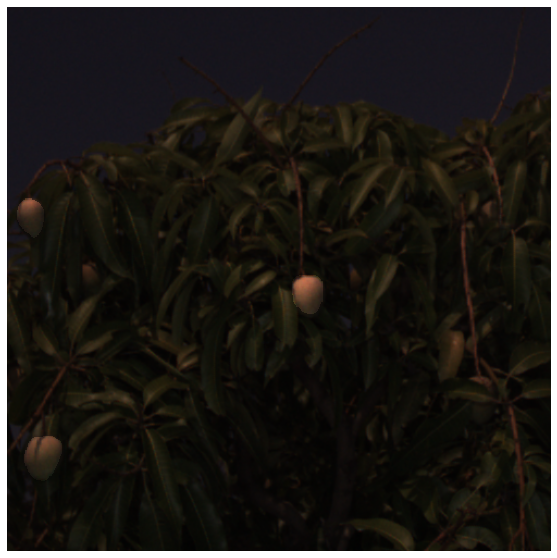

In [400]:
get_y_fn = lambda x: mask_path/f'{x.stem}_mask.png'
img_f = fnames[7]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), convert_mode='RGB', div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

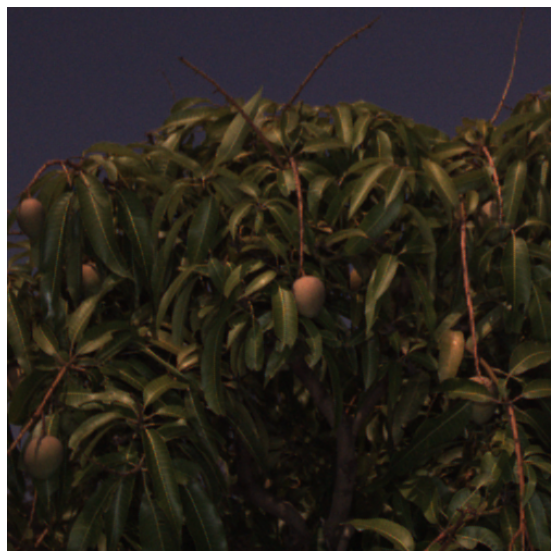

In [399]:
get_y_fn = lambda x: mask_path/f'{x.stem}_mask.png'
img_f = fnames[7]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), convert_mode='RGB', div=False)

fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
# mask.show(ax=ax, alpha=0.5)

In [292]:
data2


ImageDataBunch;

Train: LabelList (32 items)
x: SegItemListCustom
Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500),Image (3, 500, 500)
y: SegLabelListCustom
ImageSegment (3, 500, 500),ImageSegment (3, 500, 500),ImageSegment (3, 500, 500),ImageSegment (3, 500, 500),ImageSegment (3, 500, 500)
Path: /content/repo/Fruit-Detection-in-Orchards/RipenessAnalysis/Images;

Valid: LabelList (2 items)
x: SegItemListCustom
Image (3, 500, 500),Image (3, 500, 500)
y: SegLabelListCustom
ImageSegment (3, 500, 500),ImageSegment (3, 500, 500)
Path: /content/repo/Fruit-Detection-in-Orchards/RipenessAnalysis/Images;

Test: None

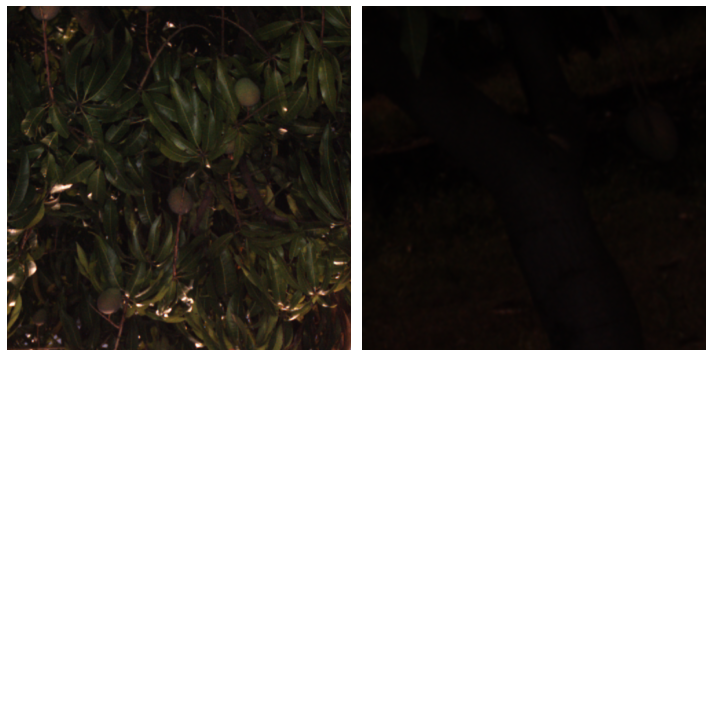

In [372]:
data2.show_batch(8,figsize=(10,10), alpha=0.)

valid_9.png


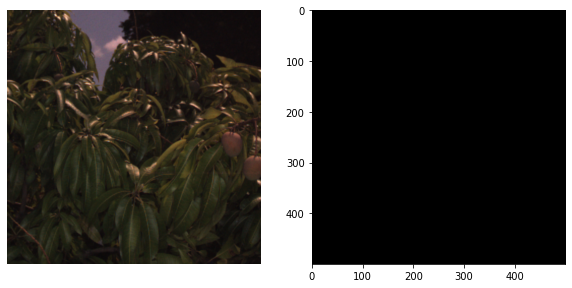

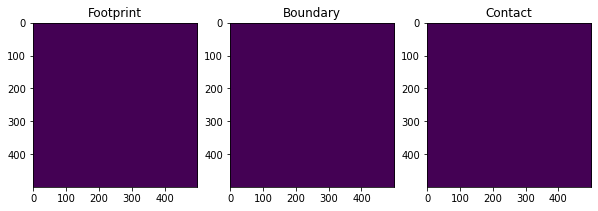

valid_8.png


IndexError: ignored

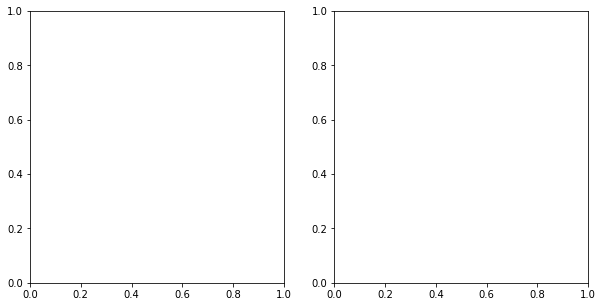

In [373]:

for idx in range(0,2):
    print(data2.valid_ds.items[idx].name)
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
    data.valid_ds.x[idx].show(ax=ax1)
    ax2.imshow(image2np(data2.valid_ds.y[idx].data*255))
    plt.show()
    show_3ch(data2.valid_ds.y[idx])

In [401]:

learn = unet_learner(data2, models.resnet50, model_dir='models',
                     metrics=metrics, 
                     loss_func=MultiChComboLoss(
                        reduction='mean',
                        loss_funcs=[FocalLoss(gamma=1, alpha=0.95),
                                    DiceLoss(),
                                   ], 
                        loss_wts=[1,1],
                        ch_wts=[1,1,1])
                    )

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [402]:

learn.loss_func

MultiChComboLoss()

In [403]:

learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 250, 250]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 250, 250]       128        True      
______________________________________________________________________
ReLU                 [64, 250, 250]       0          False     
______________________________________________________________________
MaxPool2d            [64, 125, 125]       0          False     
______________________________________________________________________
Conv2d               [64, 125, 125]       4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 125, 125]       128        True      
______________________________________________________________________
Conv2d               [64, 125, 125]       36,864     False     
__________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-02
Min loss divided by 10: 6.92E-05


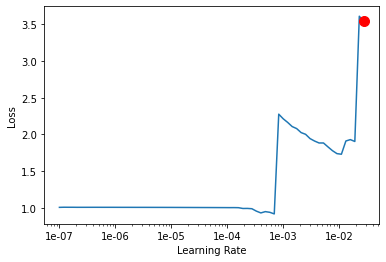

In [404]:

learn1.lr_find()
learn1.recorder.plot(0,2,suggestion=True)

In [405]:

lr = 1e-6
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                         monitor='dice_multich',
                                         mode='max',
                                         name='znz001trn-focaldice-stage1-best')
                    ]
                   )


epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,acc_thresh_multich,dice_multich,time
0,1.618218,1.446733,0.232588,0.000000,0.015374,0.000000,00:28
1,1.590904,1.399873,0.322157,0.000000,0.088392,0.000000,00:09
2,1.532954,1.307712,0.633127,0.000000,0.530216,0.000000,00:09
3,1.462786,1.217529,0.889095,0.000000,0.898010,0.000000,00:09
4,1.399566,1.156237,0.961857,0.000000,0.957586,0.000000,00:09
5,1.344820,1.118326,0.977397,0.000000,0.973014,0.000000,00:10
6,1.300353,1.096477,0.981145,0.000000,0.979306,0.000000,00:10
7,1.264485,1.084716,0.982116,0.000000,0.982448,0.000000,00:10
8,1.235802,1.079185,0.981153,0.000000,0.983968,0.000000,00:10
9,1.212413,1.076213,0.979447,0.000000,0.984810,0.000000,00:10


Better model found at epoch 0 with dice_multich value: 0.0.


In [406]:

learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=3,with_loss=True)
losses.shape

torch.Size([2, 1, 500, 500])

In [407]:

losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)
losses_reshaped.shape

torch.Size([2])

In [408]:

def show_3ch(imgitem, figsize=(10,5)):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=figsize)
    ax1.imshow(np.asarray(imgitem.data[0,None])[0])
    ax2.imshow(np.asarray(imgitem.data[1,None])[0])
    ax3.imshow(np.asarray(imgitem.data[2,None])[0])
    
    ax1.set_title('Footprint')
    ax2.set_title('Boundary')
    ax3.set_title('Contact')
    
    plt.show()

In [ ]:
# tensor(2)
# data2.train_ds.items[tensor(2)].name
# data2.train_ds.x[tensor(1)]


valid_9.png
loss: 1.4556119441986084


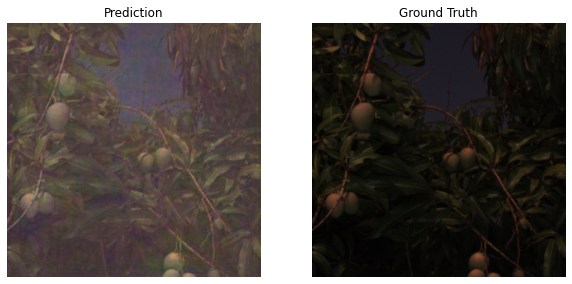

Predicted:


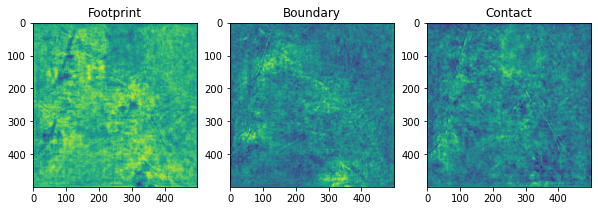

Actual:


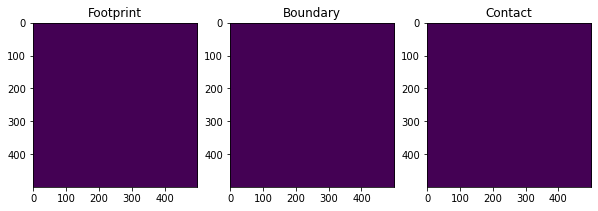

valid_8.png
loss: 1.4378528594970703


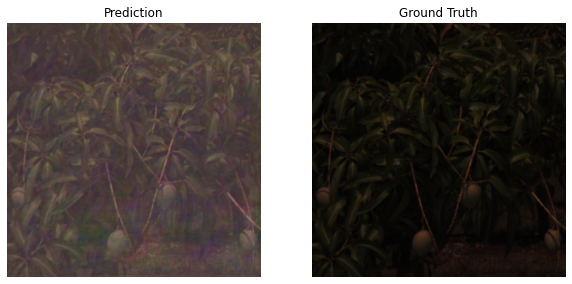

Predicted:


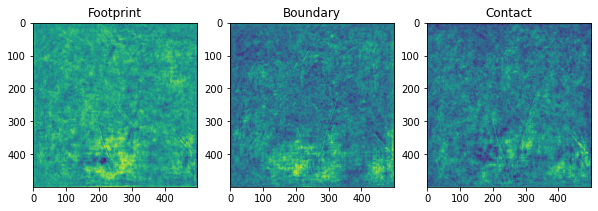

Actual:


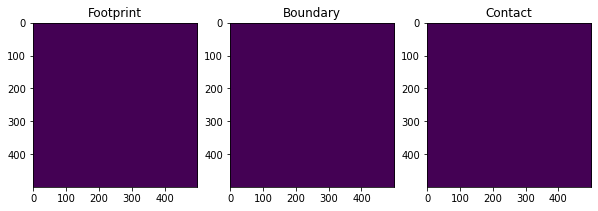

In [409]:

# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:10]:

    print(f'{data2.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data2.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid()), alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data2.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    
    print('Predicted:')
    show_3ch(outputs[i].sigmoid())
    print('Actual:')
    show_3ch(labels[i])

In [391]:

learn.unfreeze()

In [392]:
learn.lr_find()


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-04


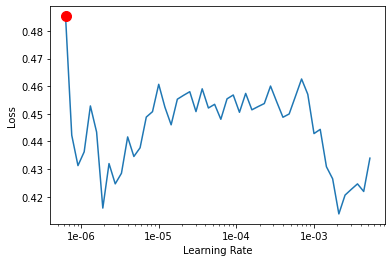

In [393]:

learn.recorder.plot(suggestion=True)

In [394]:

learn.fit_one_cycle(20, max_lr=slice(3e-6,3e-4), 
                    callbacks=[
                        SaveModelCallback(learn,
                                           monitor='dice_multich',
                                           mode='max',
                                           name='znz001trn-focaldice-unfrozen-best')
                    ]
                   )

epoch,train_loss,valid_loss,acc_thresh_multich,dice_multich,acc_thresh_multich,dice_multich,time
0,0.475716,0.020969,1.000000,1.000000,1.000000,1.000000,00:01
1,0.443899,0.036921,1.000000,1.000000,1.000000,1.000000,00:02
2,0.398371,0.000743,1.000000,1.000000,1.000000,1.000000,00:01
3,0.419939,0.000002,1.000000,1.000000,1.000000,1.000000,00:01
4,0.421278,0.000002,1.000000,1.000000,1.000000,1.000000,00:01
5,0.433213,0.000029,1.000000,1.000000,1.000000,1.000000,00:01
6,0.439464,0.016429,1.000000,1.000000,1.000000,1.000000,00:01
7,0.444587,0.000004,1.000000,1.000000,1.000000,1.000000,00:01
8,0.434713,0.000003,1.000000,1.000000,1.000000,1.000000,00:01
9,0.440811,0.000063,1.000000,1.000000,1.000000,1.000000,00:01


Better model found at epoch 0 with dice_multich value: 1.0.


In [395]:

learn.model.eval()
outputs,labels,losses = learn.get_preds(ds_type=DatasetType.Valid,n_batch=6,with_loss=True)
losses_reshaped = torch.mean(losses.view(outputs.shape[0],-1), dim=1)
sorted_idx = torch.argsort(losses_reshaped,descending=True)

valid_8.png
loss: 0.020968656986951828


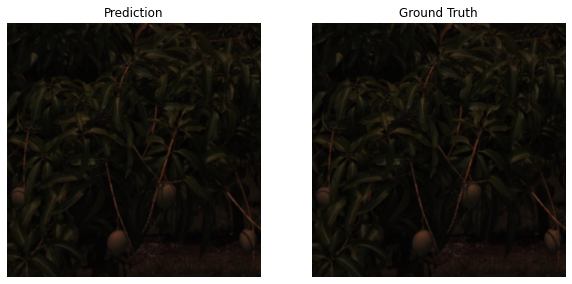

Predicted:


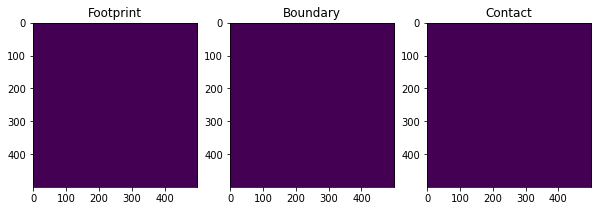

Actual:


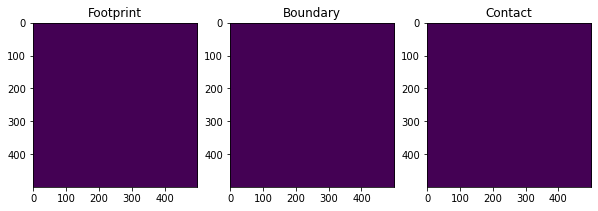

valid_9.png
loss: 0.02096865512430668


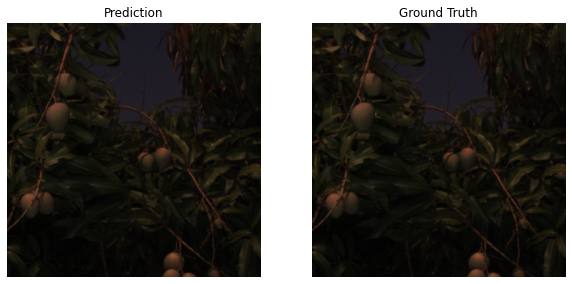

Predicted:


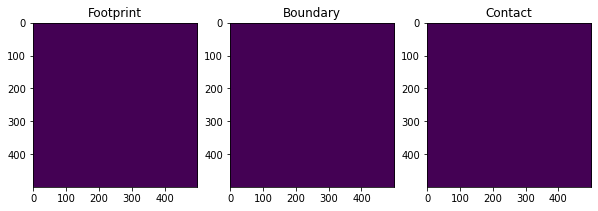

Actual:


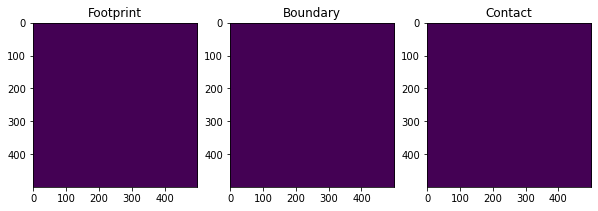

In [397]:

# look at predictions vs actual by channel sorted by highest image-wise loss first

for i in sorted_idx[:10]:

    print(f'{data2.valid_ds.items[i].name}')
    print(f'loss: {losses_reshaped[i].mean()}')
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    
    data2.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow(image2np(outputs[i].sigmoid()), alpha=0.4)
    
    ax2.set_title('Ground Truth')
    data2.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(image2np(labels[i])*255, alpha=0.4)
    plt.show()
    
    print('Predicted:')
    show_3ch(outputs[i].sigmoid())
    print('Actual:')
    show_3ch(labels[i])

In [1]:

!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *

from fastai.vision.all import *

!git clone https://github.com/PavanproJack/Fruit-Detection-in-Orchards.git



     |████████████████████████████████| 727kB 8.6MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 1.2MB 40.6MB/s 
     |████████████████████████████████| 194kB 51.4MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
Mounted at /content/gdrive
Cloning into 'Fruit-Detection-in-Orchards'...
remote: Enumerating objects: 13999, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 13999 (delta 116), reused 193 (delta 61), pack-reused 13725
Receiving objects: 100% (13999/13999), 2.14 GiB | 35.17 MiB/s, done.
Resolving deltas: 100% (257/257), done.


In [3]:

os.chdir('/content/Fruit-Detection-in-Orchards/RipenessAnalysis/Ripen')
!ls | xargs -I {} mv {} 1_{}
os.chdir('/content/Fruit-Detection-in-Orchards/RipenessAnalysis/UnRipe')
!ls | xargs -I {} mv {} 2_{}

os.chdir('/content/')
!mkdir /content/mango_pics2
! cp /content/Fruit-Detection-in-Orchards/RipenessAnalysis/Ripen/* /content/mango_pics2
! cp /content/Fruit-Detection-in-Orchards/RipenessAnalysis/UnRipe/* /content/mango_pics2


In [4]:


path='/content/mango_pics2'

def is_ripe(x): 
  return x[0]=='1'

get_y_fn = lambda x: x[0]=='1'
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
  label_func=is_ripe, item_tfms=Resize(224),bs=2)

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(20)


# uploader = SimpleNamespace(data = ['/content/mango_pics2/1_1_1_1img_1_7_0_Mangos.jpg (1).jpg'])

# img = PILImage.create(uploader.data[0])
# is_cat,_,probs = learn.predict(img)
# print(f"Is this a cat?: {is_cat}.")
# print(f"Probability it's a cat: {probs[1].item():.6f}")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.844343,1.503271,0.500000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.502515,0.726300,0.250000,00:00
1,0.986492,1.254816,1.000000,00:00
2,1.117517,1.219096,0.750000,00:00
3,1.238611,0.241094,0.000000,00:00
4,1.174733,0.177931,0.000000,00:00
5,1.161452,0.217313,0.000000,00:00
6,1.174111,0.215893,0.000000,00:00
7,1.183490,0.435452,0.500000,00:00
8,1.045744,0.547999,0.250000,00:00
9,0.916117,0.467255,0.250000,00:00


In [5]:

uploader = SimpleNamespace(data = ['/content/mango_pics2/1_img_1_7_0_Mangos.jpg (1).jpg'])

img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.174596


In [6]:

# learn.export()
learn.export('mango_model.pkl')

In [7]:
learn.export('model.pkl')

In [17]:
learn.save('ripe_mango_pred.pkl')

Path('/content/mango_pics2/models/ripe_mango_pred.pkl.pth')

In [8]:

uploader = SimpleNamespace(data = ['/content/mango_pics2/1_img_1_7_0_Mangos.jpg (1).jpg'])

img = PILImage.create(uploader.data[0])

In [40]:

!pip install --user pypi-packagename

ERROR: Could not find a version that satisfies the requirement pypi-packagename (from versions: none)
ERROR: No matching distribution found for pypi-packagename


In [9]:
learn_inf = load_learner('/content/mango_pics2/model.pkl')
is_cat,_,probs = learn_inf.predict(img)
print(f"Is Mango Ripe?: {is_cat}.")
print(f" Ripe Probability : {probs[1].item():.6f}")

Is Mango Ripe?: False.
 Ripe Probability : 0.174599


In [10]:
btn_run = widgets.Button(description='Classify')


In [11]:

def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    is_ripe,_,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {is_ripe}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [12]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [13]:

VBox([widgets.Label('Select a mango picture to check if it is ripe'),btn_upload, btn_run, out_pl, lbl_pred])
